<a href="https://colab.research.google.com/github/ju-dominguez/baseball-stats/blob/main/SPRING25_CTBL_STATS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ========== CONFIGURATION ==========



In [83]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

In [91]:
BASE_URL = "https://www.capitaloftexasbaseball.org/teams/default.asp"
PARAMS = {
    "p": "stats",
    "bsort": "plateappearances",
    "u": "CTBL",
    "s": "baseball"
}
MAX_PAGES = 10
IDENTITY_COLS = ["Name", "Team"]
MIN_PA = 10  # Minimum Plate Appearances to qualify
ADV_STATS = ["AVG", "OBP", "SLG", "OPS", "wOBA", "wRAA"]
YOUR_NAME = "Dominguez, Julian"
YOUR_TEAM = "Austin Baseball Club"

## ========== HELPERS ==========

In [32]:
def get_qualified(df, min_pa=MIN_PA):
    return df[df["PA"] >= min_pa]

In [77]:
# Custom formatter to remove leading 0
def trim_zero(val):
    if isinstance(val, float):
        return f"{val:.3f}".lstrip("0")
    return val

## ========== SCRAPING & CLEANING ==========

In [33]:
def scrape_league_stats(base_url, params, max_pages=10):
    all_data = []
    page = 1

    while page <= max_pages:
        print(f"🔍 Scraping page {page}...")
        if page > 1:
            params["bpageNum"] = page
        else:
            params.pop("bpageNum", None)

        response = requests.get(base_url, params=params)
        soup = BeautifulSoup(response.content, "html.parser")
        table = soup.find("table")

        if not table:
            print("❌ No table found. Stopping.")
            break

        rows = table.find_all("tr")
        if len(rows) < 2:
            print("❌ No data rows. Stopping.")
            break

        header = [td.text.strip() for td in rows[0].find_all("td")]
        data_rows = [
            [td.text.strip() for td in row.find_all("td")]
            for row in rows[1:]
            if len(row.find_all("td")) == len(header)
        ]

        if not data_rows:
            print("❌ No valid player rows. Stopping.")
            break

        all_data.extend(data_rows)
        page += 1

    return pd.DataFrame(all_data, columns=header)

def clean_and_convert(df, identity_cols):
    cols_to_convert = [col for col in df.columns if col not in identity_cols]
    df.replace({'-': 0, '': 0}, inplace=True)
    df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')
    return df

## ========== METRIC CALCULATIONS ==========

In [45]:
def calculate_woba_and_wraa(df, woba_scale=1.15, min_pa=MIN_PA):
    df["1B"] = df["H"] - df["2B"] - df["3B"] - df["HR"]
    df["wOBA_numerator"] = (
        0.69 * df["BB"] +
        0.72 * df["HBP"] +
        0.89 * df["1B"] +
        1.27 * df["2B"] +
        1.62 * df["3B"] +
        2.10 * df["HR"]
    )
    df["wOBA_denominator"] = df["AB"] + df["BB"] + df["HBP"]
    df["wOBA"] = df["wOBA_numerator"] / df["wOBA_denominator"]

    qualified = get_qualified(df, min_pa)
    league_woba = qualified["wOBA"].mean()

    df["wRAA"] = ((df["wOBA"] - league_woba) / woba_scale) * df["PA"]
    return df, league_woba

## ========== DISPLAY FUNCTIONS ==========

In [92]:
def display_team_stat_leaders(df, team_name, stat_cols, min_pa=MIN_PA, top_n=10):
    team_df = df[(df["Team"] == team_name) & (df["PA"] >= min_pa)]
    if team_df.empty:
        print(f"⚠️ No qualified players found for {team_name}.")
        return
    for stat in stat_cols:
        print(f"\n🏆 Top {top_n} on {team_name} by {stat}:")
        leaderboard = team_df.sort_values(by=stat, ascending=False)[["Name", "PA", stat]].head(top_n)
        leaderboard["Name"] = leaderboard["Name"].apply(lambda n: f"👉 {n}" if n == YOUR_NAME else n)
        display(leaderboard)

def plot_stat_leaders(df, stat, min_pa=MIN_PA, top_n=10):
    qualified = get_qualified(df, min_pa)
    leaders = qualified.sort_values(by=stat, ascending=False).head(top_n)

    plt.figure(figsize=(10, 5))
    bars = plt.barh(leaders["Name"], leaders[stat])
    plt.gca().invert_yaxis()
    plt.title(f"Top {top_n} Players by {stat}")
    plt.xlabel(stat)
    plt.tight_layout()
    plt.show()

def plot_leaderboard(df, stat, your_name, min_pa=MIN_PA, top_n=10):
    qualified = get_qualified(df, min_pa)
    leaders = qualified.sort_values(by=stat, ascending=False).head(top_n)
    color_map = ['orange' if name == your_name else 'gray' for name in leaders["Name"]]

    plt.figure(figsize=(10, 5))
    bars = plt.barh(leaders["Name"], leaders[stat], color=color_map)
    plt.gca().invert_yaxis()
    plt.title(f"Top {top_n} Players by {stat} (League-Wide)")
    plt.xlabel(stat)
    plt.tight_layout()
    plt.show()

In [93]:
# Team batting order functions
def calculate_handedness_score(lineup):
    score = 0
    count = 1
    for i in range(1, len(lineup)):
        prev = lineup.iloc[i - 1]["Bats"]
        curr = lineup.iloc[i]["Bats"]
        if curr == prev:
            count += 1
            score += 1
            if count >= 3:
                score += 1  # extra penalty for 3+ in a row
        else:
            count = 1
    return score

def optimize_for_handedness(lineup, override_spots=None, max_offset=2, max_perf_drop=0.05):
    if override_spots is None:
        override_spots = {}

    best_lineup = lineup.copy()
    best_score = calculate_handedness_score(best_lineup)

    improved = True
    while improved:
        improved = False
        for i, j in combinations(range(len(best_lineup)), 2):
            # Don't swap manually overridden spots
            if i in override_spots.values() or j in override_spots.values():
                continue
            if abs(i - j) > max_offset:
                continue

            swapped = best_lineup.copy()
            swapped.iloc[i], swapped.iloc[j] = swapped.iloc[j].copy(), swapped.iloc[i].copy()

            new_score = calculate_handedness_score(swapped)
            perf_delta = abs(swapped.iloc[i]["batting_value"] - best_lineup.iloc[i]["batting_value"]) + \
                         abs(swapped.iloc[j]["batting_value"] - best_lineup.iloc[j]["batting_value"])

            if new_score < best_score and perf_delta <= max_perf_drop:
                best_lineup = swapped
                best_score = new_score
                improved = True
                break

    return best_lineup

def generate_optimized_batting_order(df, team_name, handedness_dict, override_spots=None, min_pa=MIN_PA):
    if override_spots is None:
        override_spots = {}

    team_df = get_qualified(df[df["Team"] == team_name], min_pa).copy()
    if team_df.empty:
        print(f"⚠️ No qualified players found for {team_name}.")
        return

    # Assign handedness
    team_df["Bats"] = team_df["Name"].apply(lambda name: handedness_dict.get(name, "R"))

    # Normalize advanced stats
    for stat in ADV_STATS:
        max_val = team_df[stat].max()
        team_df[f"{stat}_score"] = team_df[stat] / max_val if max_val > 0 else 0

    # Contact score (inverse K rate)
    team_df["K_rate"] = (team_df["SO"] / team_df["PA"]).fillna(0)
    team_df["contact_score"] = 1 - team_df["K_rate"]

    # Composite score
    team_df["batting_value"] = (
        0.22 * team_df["OBP_score"] +
        0.18 * team_df["SLG_score"] +
        0.15 * team_df["OPS_score"] +
        0.15 * team_df["wRAA_score"] +
        0.15 * team_df["wOBA_score"] +
        0.10 * team_df["AVG_score"] +
        0.05 * team_df["contact_score"]
    )

    # Initial sort by batting value
    lineup = team_df.sort_values(by="batting_value", ascending=False).reset_index(drop=True)

    # Handle manual overrides
    if override_spots:
        fixed = lineup[lineup["Name"].isin(override_spots.keys())].copy()
        floating = lineup[~lineup["Name"].isin(override_spots.keys())].copy()

        fixed["Forced Index"] = fixed["Name"].map(override_spots)
        fixed = fixed.sort_values("Forced Index")

        available_idxs = [i for i in range(len(lineup)) if i not in override_spots.values()]
        floating = floating.sort_values("batting_value", ascending=False).reset_index(drop=True)
        floating["Forced Index"] = available_idxs

        lineup = pd.concat([fixed, floating]).sort_values("Forced Index").reset_index(drop=True)

    # Assign order
    lineup["Batting Order"] = [f"{i+1}" for i in range(len(lineup))]

    # Optimize for handedness (with locked override spots)
    lineup = optimize_for_handedness(lineup, override_spots)

    # Round columns
    round_cols = ["AVG", "OBP", "SLG", "OPS", "wOBA", "wRAA", "K_rate"]
    lineup[round_cols] = lineup[round_cols].round(3)

    # Split into lineup and bench
    lineup_df = lineup.iloc[:9].copy()
    bench_df = lineup.iloc[9:].copy()

    # Select display columns
    display_cols = ["Batting Order", "Bats", "Name", "AVG", "OBP", "SLG", "OPS"]

    # Define stat columns to apply formatter
    stat_cols_trimmed = ["AVG", "OBP", "SLG", "OPS"]

    # Display lineup (top 9)
    print("🧢 Optimized Batting Lineup:")
    display(
        lineup_df[["Batting Order", "Bats", "Name"] + stat_cols_trimmed]
        .style
        .hide(axis="index")
        .format({col: trim_zero for col in stat_cols_trimmed})
    )

    # Display bench
    if not bench_df.empty:
        print("\n🪑 Bench Players:")
        display(
            bench_df[["Batting Order", "Bats", "Name"] + stat_cols_trimmed]
            .style
            .hide(axis="index")
            .format({col: trim_zero for col in stat_cols_trimmed})
        )


## ========== MAIN EXECUTION ==========

In [36]:
# 1. Scrape
df = scrape_league_stats(BASE_URL, PARAMS, MAX_PAGES)
print(f"\n✅ Scraping complete: {len(df)} rows collected.")

🔍 Scraping page 1...
🔍 Scraping page 2...
🔍 Scraping page 3...
🔍 Scraping page 4...
🔍 Scraping page 5...
🔍 Scraping page 6...
🔍 Scraping page 7...
🔍 Scraping page 8...
🔍 Scraping page 9...
🔍 Scraping page 10...

✅ Scraping complete: 280 rows collected.


In [37]:
# 2. Clean & convert
df = clean_and_convert(df, IDENTITY_COLS)

In [47]:
# 3. Add wOBA and wRAA
df, league_woba = calculate_woba_and_wraa(df)

## ========== Results ==========

In [94]:
# 4. Display team stat leaders
display_team_stat_leaders(df, YOUR_TEAM, ADV_STATS, MIN_PA)


🏆 Top 10 on Austin Baseball Club by AVG:


,Name,PA,AVG
13,"Hedrick, Paul",22,0.529
45,"👉 Dominguez, Julian",16,0.500
100,"Mendez, Erik",10,0.500
85,"King, Demarcus",11,0.429
38,"Lenaburg, Clay",17,0.385
36,"Cho, Jason",17,0.333
57,"Berg, Adam",14,0.300
26,"Peabody, Edward",19,0.294
72,"Feltner, Ryan",12,0.286
62,"Hall, Austin",13,0.250



🏆 Top 10 on Austin Baseball Club by OBP:


,Name,PA,OBP
85,"King, Demarcus",11,0.636
45,"👉 Dominguez, Julian",16,0.625
100,"Mendez, Erik",10,0.600
13,"Hedrick, Paul",22,0.591
72,"Feltner, Ryan",12,0.583
38,"Lenaburg, Clay",17,0.529
57,"Berg, Adam",14,0.500
36,"Cho, Jason",17,0.412
26,"Peabody, Edward",19,0.368
77,"Manzo, Eli",12,0.333



🏆 Top 10 on Austin Baseball Club by SLG:


,Name,PA,SLG
45,"👉 Dominguez, Julian",16,0.833
38,"Lenaburg, Clay",17,0.615
13,"Hedrick, Paul",22,0.529
100,"Mendez, Erik",10,0.500
72,"Feltner, Ryan",12,0.429
85,"King, Demarcus",11,0.429
36,"Cho, Jason",17,0.400
62,"Hall, Austin",13,0.333
57,"Berg, Adam",14,0.300
26,"Peabody, Edward",19,0.294



🏆 Top 10 on Austin Baseball Club by OPS:


,Name,PA,OPS
45,"👉 Dominguez, Julian",16,1.458
38,"Lenaburg, Clay",17,1.145
13,"Hedrick, Paul",22,1.120
100,"Mendez, Erik",10,1.100
85,"King, Demarcus",11,1.065
72,"Feltner, Ryan",12,1.012
36,"Cho, Jason",17,0.812
57,"Berg, Adam",14,0.800
26,"Peabody, Edward",19,0.663
62,"Hall, Austin",13,0.641



🏆 Top 10 on Austin Baseball Club by wOBA:


,Name,PA,wOBA
45,"👉 Dominguez, Julian",16,0.601250
13,"Hedrick, Paul",22,0.512857
100,"Mendez, Erik",10,0.497000
85,"King, Demarcus",11,0.496364
38,"Lenaburg, Clay",17,0.489412
72,"Feltner, Ryan",12,0.472500
57,"Berg, Adam",14,0.390000
36,"Cho, Jason",17,0.368824
26,"Peabody, Edward",19,0.306842
62,"Hall, Austin",13,0.287692



🏆 Top 10 on Austin Baseball Club by wRAA:


,Name,PA,wRAA
45,"👉 Dominguez, Julian",16,3.140626
13,"Hedrick, Paul",22,2.627367
38,"Lenaburg, Clay",17,1.683654
85,"King, Demarcus",11,1.155919
100,"Mendez, Erik",10,1.056369
72,"Feltner, Ryan",12,1.011991
57,"Berg, Adam",14,0.176309
36,"Cho, Jason",17,-0.098954
62,"Hall, Austin",13,-0.992807
26,"Peabody, Edward",19,-1.134637


In [95]:
handedness = {
    'King, Demarcus': 'L',
    'Cho, Jason': 'L',
    'Manzo, Joel': 'L',
    'Hedrick, Paul': 'S'
}

override_spots = {
    'King, Demarcus': 0,  # Force to Leadoff
    'Hedrick, Paul': 3,   # Force to Cleanup
    'Cho, Jason': 6,      # Force to 7th
}

generate_optimized_batting_order(df, YOUR_TEAM, handedness, override_spots)


🧢 Optimized Batting Lineup:


Batting Order,Bats,Name,AVG,OBP,SLG,OPS
1,L,"King, Demarcus",.429,.636,.429,1.065
2,R,"Dominguez, Julian",.500,.625,.833,1.458
3,R,"Lenaburg, Clay",.385,.529,.615,1.145
4,S,"Hedrick, Paul",.529,.591,.529,1.120
5,R,"Mendez, Erik",.500,.600,.500,1.100
6,R,"Feltner, Ryan",.286,.583,.429,1.012
7,L,"Cho, Jason",.333,.412,.400,.812
8,R,"Berg, Adam",.300,.500,.300,.800
9,R,"Peabody, Edward",.294,.368,.294,.663



🪑 Bench Players:


Batting Order,Bats,Name,AVG,OBP,SLG,OPS
10,R,"Hall, Austin",.250,.308,.333,.641
11,R,"Manzo, Eli",.200,.333,.200,.533
12,L,"Manzo, Joel",.083,.267,.083,.350
13,R,"Vega, Joe",.167,.167,.167,.333
14,R,"McPhee, Ed",.000,.182,.000,.182


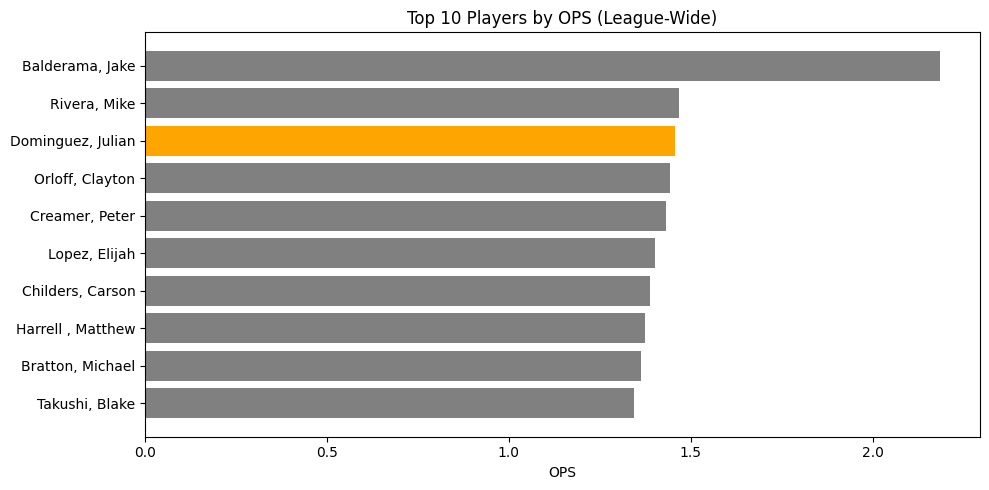

In [80]:
plot_leaderboard(df, "OPS", YOUR_NAME)

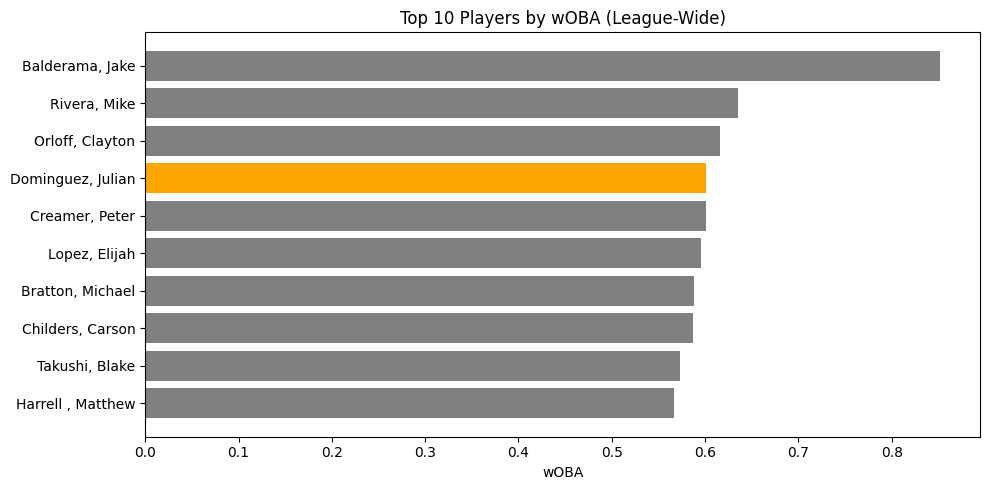

In [81]:
plot_leaderboard(df, "wOBA", YOUR_NAME)